In [1]:
import numpy as np
from matplotlib import pyplot as plt, tri
from scipy.sparse import linalg, coo_matrix

import pickle

import torch
import torch.nn as nn
import torch.optim as optim

import nbimporter
from NN_Local_Ks_1 import *

from time import time

In [2]:
# Material Properties
# = = = = = = = = = = = = = =

E  = 1.0
nu = 0.3

Bs = {}

In [3]:
# Reading Mesh
# = = = = = = = = = = = = = =

def read_mesh(mesh_name):
    nodes_dict = {}
    elems_dict = {}
    
    # Reading nodes
    nodes_file = open(mesh_name + '_nodes.txt', 'r')

    for line in nodes_file:
        data_tokens = list(map(float, line.split(' ')))
        node_ID = int(data_tokens[0])
        coord_array = data_tokens[1:]
        nodes_dict[node_ID] = coord_array

    nodes_file.close()

    # Reading elems
    elems_file = open(mesh_name + '_elems.txt', 'r')

    for line in elems_file:
        if (line == ''):
            break
        data_tokens = list(map(int, line.replace(' \n', '').split(' ')))
        elem_ID = data_tokens[0]
        elem_nodes = data_tokens[1:]
        elems_dict[elem_ID] = elem_nodes
        
    elems_file.close()

    print(f'Mesh from [{mesh_name}] loaded.\n')
    return nodes_dict, elems_dict

In [4]:
# Searching for mesh borders
# = = = = = = = = = = = = = =

def mesh_borders(nodes_dict):
    min_x = 1e9
    max_x = -1e9
    min_y = 1e9
    max_y = -1e9

    for node_id in list(nodes_dict.keys()):
        node_x, node_y, node_z = tuple(nodes_dict[node_id])
        if (node_x > max_x):
            max_x = node_x
        if (node_x < min_x):
            min_x = node_x
        if (node_y > max_y):
            max_y = node_y
        if (node_y < min_y):
            min_y = node_y
            
    return (min_x, max_x, min_y, max_y)
                
def kirsh_bounds(nodes_dict, min_x, max_x, min_y, max_y):
    node_IDs_upper = []
    node_IDs_bottom = []
    node_IDs_left = []
    node_IDs_right = []
    
    tol = 1e-7
    
    for node_id in list(nodes_dict.keys()):
        node_y = nodes_dict[node_id][1]
        node_x = nodes_dict[node_id][0]
        if abs(node_y - max_y) < tol:
            node_IDs_upper.append(node_id)
        if abs(node_y - min_y) < tol:
            node_IDs_bottom.append(node_id)
        if abs(node_x - min_x) < tol:
            node_IDs_left.append(node_id)
        if abs(node_x - max_x) < tol:
            node_IDs_right.append(node_id)
            
    return node_IDs_upper, node_IDs_bottom, node_IDs_left, node_IDs_right

In [5]:
# Hook's Law in matrix form
# = = = = = = = = = = = = = =

D = np.array([
    [1-nu, nu,   0],
    [nu,   1-nu, 0],
    [0,    0,    (1-2*nu)/2]
]) / ((1 + nu)*(1 - 2*nu))

In [6]:
# Local stiffness matrix
# = = = = = = = = = = = = = =

def local_K(elem_id):
    node_1, node_2, node_3 = elems_dict[elem_id]
    x1, y1 = nodes_dict[node_1][0], nodes_dict[node_1][1]
    x2, y2 = nodes_dict[node_2][0], nodes_dict[node_2][1]
    x3, y3 = nodes_dict[node_3][0], nodes_dict[node_3][1]
    
    area = 0.5 * ((x2-x1)*(y3-y1) - (x3-x1)*(y2-y1))
    
    
    Jacobian = np.array([
        [x2 - x1, y2 - y1],
        [x3 - x1, y3 - y1]
    ])

    inv_Jacobian = np.linalg.inv(Jacobian)
    a = inv_Jacobian[0][0]
    b = inv_Jacobian[0][1]
    c = inv_Jacobian[1][0]
    d = inv_Jacobian[1][1]

    B = np.array([
        [-a-b, 0,    a, 0, b, 0],
        [0,    -c-d, 0, c, 0, d],
        [-c-d, -a-b, c, a, d, b]
    ])
    
    Bs[elem_id] = B
    
    Ke = 0.5 * B.T @ D @ B * np.linalg.det(Jacobian)
    
    return Ke

In [7]:
# Global stiffness matrix
# = = = = = = = = = = = = = =

def global_K(nodes, elems):
    I = []
    J = []
    A = []
    
    # Number of degrees of freedom
    K_shape = len(nodes)*2

    KEs = []
    
    for elem in elems:
        Ke = local_K(elem)
        KEs.append(Ke)
        node_1, node_2, node_3 = elems[elem]
        local_dofs = [node_1*2, node_1*2+1, node_2*2, node_2*2+1, node_3*2, node_3*2+1]
        for i in range(6):
            for j in range(6):
                I.append(local_dofs[i])
                J.append(local_dofs[j])
                A.append(Ke[i][j])
                
    K = coo_matrix((A, (I, J)), shape = (K_shape, K_shape)).tocsr()
    return K, KEs


def global_K_neural(nodes, elems_characteristics, elems, model_name):
    model = StiffnessPredictor_1()
    model.load_state_dict(torch.load(model_name))
    model.eval()
    nn_start = time()
    KEs = np.array(model(torch.FloatTensor(elems_characteristics)).detach())
    nn_end = time()
    print(f'NN Local Ks calc: {nn_end - nn_start :.6f} sec')

    I = []
    J = []
    A = []
    
    # Number of degrees of freedom
    K_shape = len(nodes)*2
    
    for i, elem in enumerate(elems):
        Ke = np.array(KEs[i]).reshape(6,6)
        node_1, node_2, node_3 = elems[elem]
        local_dofs = [node_1*2, node_1*2+1, node_2*2, node_2*2+1, node_3*2, node_3*2+1]
        for i in range(6):
            for j in range(6):
                I.append(local_dofs[i])
                J.append(local_dofs[j])
                A.append(Ke[i][j])
                
    K = coo_matrix((A, (I, J)), shape = (K_shape, K_shape)).tocsr()
    return K, KEs

In [8]:
def fix_node(global_K, node_ID, fix_x, fix_y):
    dof_x = (node_ID)*2
    dof_y = (node_ID)*2 + 1
    
    if (fix_x == True):
        global_K[:, dof_x] = 0
        global_K[dof_x, :] = 0
        global_K[dof_x, dof_x] = 1e12
        fixed_dofs.append(dof_x)
    if (fix_y == True):
        global_K[:, dof_y] = 0
        global_K[dof_y, :] = 0
        global_K[dof_y, dof_y] = 1e12
        fixed_dofs.append(dof_y)

In [9]:
def apply_load(global_F, node_ID, load_x, load_y):
    dof_x = (node_ID)*2
    dof_y = (node_ID)*2 + 1
    
    global_F[dof_x] = load_x
    global_F[dof_y] = load_y

In [10]:
# Reading Mesh
# = = = = = = = = = = = = = =

nodes_dict, elems_dict = read_mesh('New_Mesh')
print('Nodes count: ', len(nodes_dict))
print('Elems count: ', len(elems_dict))

id_mapping = {}
for i, node in enumerate(nodes_dict):
    id_mapping[node] = i
    
new_nodes_dict = {}
new_elems_dict = {}
for node in nodes_dict:
    new_nodes_dict[id_mapping[node]] = nodes_dict[node]
    
for elem in elems_dict:
    node_1, node_2, node_3 = elems_dict[elem]
    new_elems_dict[elem] = [id_mapping[node_1], id_mapping[node_2], id_mapping[node_3]]

nodes_dict = new_nodes_dict
elems_dict = new_elems_dict

Mesh from [New_Mesh] loaded.

Nodes count:  1230
Elems count:  2334


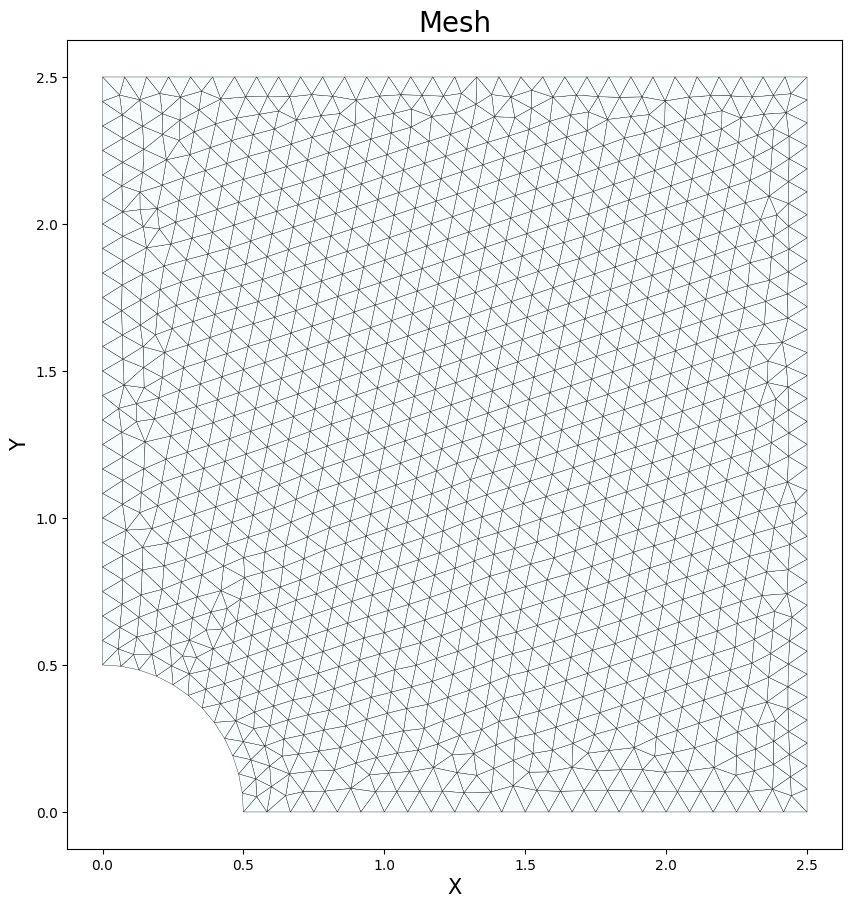

In [11]:
# Drawing mesh
# = = = = = = = = = = = = = =

Xs = []
Ys = []
Tris = []

for node_id in nodes_dict:
    Xs.append(nodes_dict[node_id][0])
    Ys.append(nodes_dict[node_id][1])
    
for elem_id in elems_dict:
    node_1, node_2, node_3 = elems_dict[elem_id]
    Tris.append((node_1, node_2, node_3))
    
mesh = tri.Triangulation(Xs, Ys, Tris)
plt.figure(figsize = (10,10.5))
plt.tripcolor(mesh, np.ones(len(Xs)), cmap = 'BuPu', edgecolors = 'black')
plt.title('Mesh', fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.show()

In [12]:
glob_K_analyt, KEs_analyt = global_K(nodes_dict, elems_dict)

In [13]:
model_name = 'Stiffness_Predictor_v1.pth'

elems_characteristics = []
for elem in elems_dict:
    node_1, node_2, node_3 = elems_dict[elem]
    x1, y1 = nodes_dict[node_1][0], nodes_dict[node_1][1]
    x2, y2 = nodes_dict[node_2][0], nodes_dict[node_2][1]
    x3, y3 = nodes_dict[node_3][0], nodes_dict[node_3][1]

    triag = [x1, y1, x2, y2, x3, y3]
    x = triag

    triag_size_x = max(abs(x[0] - x[2]), abs(x[0] - x[4]), abs(x[2] - x[4]))
    triag_size_y = max(abs(x[1] - x[3]), abs(x[3] - x[5]), abs(x[1] - x[5]))
    triag_size = max(triag_size_x, triag_size_y)

    angle_1, angle_2, angle_3 = triangle_angles(triag)
    area = triangle_area(triag)
    x1, y1, x2, y2, x3, y3 = node_shifts(triag)

    elems_characteristics.append([angle_1, angle_2, angle_3, area, x1/triag_size, y1/triag_size, x2/triag_size, y2/triag_size, x3/triag_size, y3/triag_size])

elems_characteristics = np.array(elems_characteristics)

glob_K_neural, KEs_neural = global_K_neural(nodes_dict, elems_characteristics, elems_dict, model_name)

NN Local Ks calc: 0.228211 sec


In [14]:
ke_start = time()
for elem in elems_dict:
    Ke = local_K(elem)
ke_end = time()
print(f'Analyt KE: {ke_end - ke_start :.6f}')

Analyt KE: 0.080074


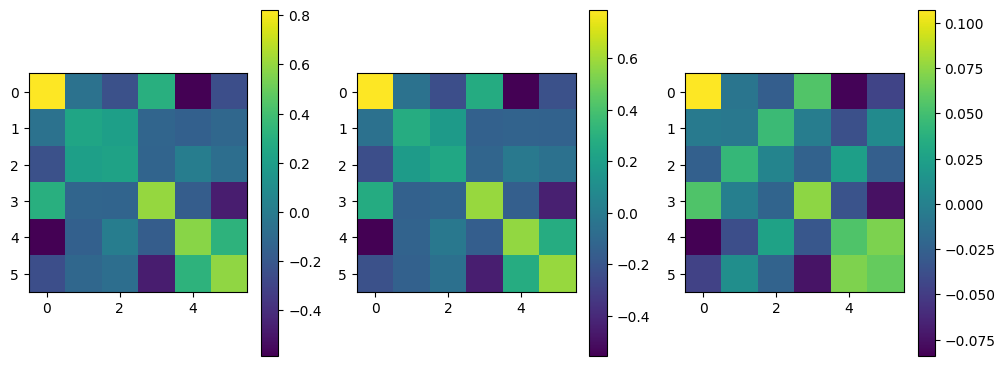

In [15]:
idx = 5

fig, axes = plt.subplots(1, 3, figsize = (12, 6))

pos0 = axes[0].imshow(KEs_analyt[idx])
pos1 = axes[1].imshow(KEs_neural[idx].reshape(6,6))
pos2 = axes[2].imshow(KEs_analyt[idx] - KEs_neural[idx].reshape(6,6)/1.1)

fig.colorbar(pos0, shrink = 0.75)
fig.colorbar(pos1, shrink = 0.75)
fig.colorbar(pos2, shrink = 0.75)

plt.show()

In [16]:
glob_delta = np.abs(glob_K_analyt.toarray() - glob_K_neural.toarray())

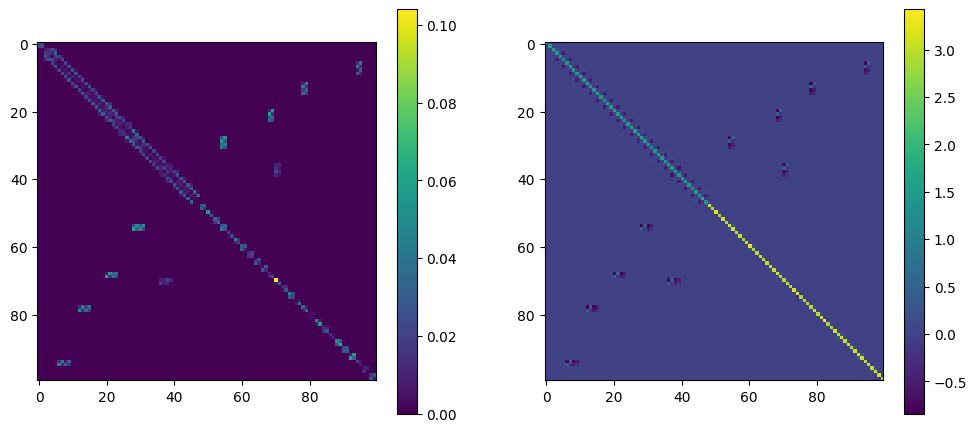

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (12, 7))

pos0 = axes[0].imshow(glob_delta[200:300, 200:300])
pos1 = axes[1].imshow(glob_K_analyt.toarray()[200:300, 200:300])

fig.colorbar(pos0, shrink = 0.75)
fig.colorbar(pos1, shrink = 0.75)

plt.show()

In [18]:
min_x, max_x, min_y, max_y = mesh_borders(nodes_dict)
up, bottom, left, right = kirsh_bounds(nodes_dict, min_x, max_x, min_y, max_y)

In [19]:
# Vectors setup
# = = = = = = = = = = = = = =

N_dofs = len(nodes_dict)*2

fixed_dofs = []
all_dofs = np.arange(N_dofs)

U_analyt = np.zeros(N_dofs)
U_neural = np.zeros(N_dofs)
F = np.zeros(N_dofs)

In [20]:
# Boundary conditions
# = = = = = = = = = = = = = =

sig_0 = 1.0
distributed_force = sig_0

for node in left:
    fix_node(glob_K_analyt, node, True, False)
    fix_node(glob_K_neural, node, True, False)
    
for node in up:
    if node in left:
        apply_load(F, node, 0, 0.5*distributed_force)
        continue
    if node in right:
        apply_load(F, node, 0, 0.5*distributed_force)
        continue
    apply_load(F, node, 0, distributed_force)
    
for node in bottom:
    fix_node(glob_K_analyt, node, False, True)
    fix_node(glob_K_neural, node, False, True)

c:\Users\mihai\Desktop\Python_3_10\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [21]:
# Solving for displacements
# = = = = = = = = = = = = = =

free_dofs = np.setdiff1d(all_dofs, fixed_dofs)
U_analyt[free_dofs] = linalg.spsolve(glob_K_analyt[free_dofs, :][:, free_dofs], F[free_dofs])
U_neural[free_dofs] = linalg.spsolve(glob_K_neural[free_dofs, :][:, free_dofs], F[free_dofs])

In [22]:
def nodal_stresses(U):
    # Calculating strains
    # = = = = = = = = = = = = = =
    Eps = {}
    for elem_id in elems_dict:
        node_1, node_2, node_3 = elems_dict[elem_id]
        dofs = [node_1*2, node_1*2+1, node_2*2, node_2*2+1, node_3*2, node_3*2+1]
        elem_u = U[dofs]
        Eps[elem_id] = Bs[elem_id] @ elem_u

    # Calculating stresses
    # = = = = = = = = = = = = = =

    Sig = {}
    for elem_id in elems_dict:
        elem_eps = Eps[elem_id]
        Sig[elem_id] = E*D @ elem_eps

    # Translating stresses from elements to nodes
    # = = = = = = = = = = = = = = = = = = = = = = = 

    stresses = [[] for i in range(len(nodes_dict))]
    for i, elem in enumerate(elems_dict):
        node_1, node_2, node_3 = elems_dict[elem]
        stress = Sig[elem][1]
        stresses[node_1].append(stress)
        stresses[node_2].append(stress)
        stresses[node_3].append(stress)
        
    node_stresses = []
    for i in range(len(stresses)):
        w_avg = np.mean(np.array(stresses[i]))
        node_stresses.append(w_avg)

    return node_stresses

In [23]:
node_stresses_analyt = nodal_stresses(U_analyt)
node_stresses_neural = nodal_stresses(U_neural)

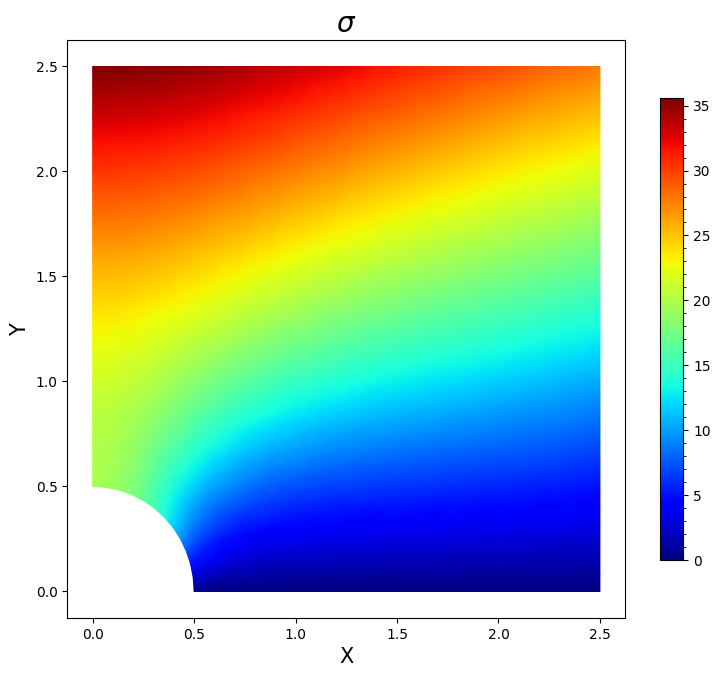

In [24]:
# Plotting stresses
# = = = = = = = = = = = = = =

Xs = []
Ys = []
Tris = []

for node_id in nodes_dict:
    Xs.append(nodes_dict[node_id][0])
    Ys.append(nodes_dict[node_id][1])
    
for elem_id in elems_dict:
    node_1, node_2, node_3 = elems_dict[elem_id]
    Tris.append((node_1, node_2, node_3))
    
mesh = tri.Triangulation(Xs, Ys, Tris)

fig, axes = plt.subplots(figsize = (9, 7.5))
axes.set_title(r'$\sigma$', fontsize = 20)
axes.set_xlabel('X', fontsize = 15)
axes.set_ylabel('Y', fontsize = 15)

displs_analyt = np.zeros(len(nodes_dict))
displs_neural = np.zeros(len(nodes_dict))
for i in range(len(nodes_dict)):
    idx = 2*i
    ux = U_analyt[idx]
    uy = U_analyt[idx+1]
    displs_analyt[i] = uy
    ux = U_neural[idx]
    uy = U_neural[idx+1]
    displs_neural[i] = uy


pos = axes.tripcolor(mesh, displs_analyt, cmap = 'jet', edgecolors = 'black', shading = 'gouraud')
cbar = fig.colorbar(pos, ax = axes, shrink = 0.8)
cbar.minorticks_on()

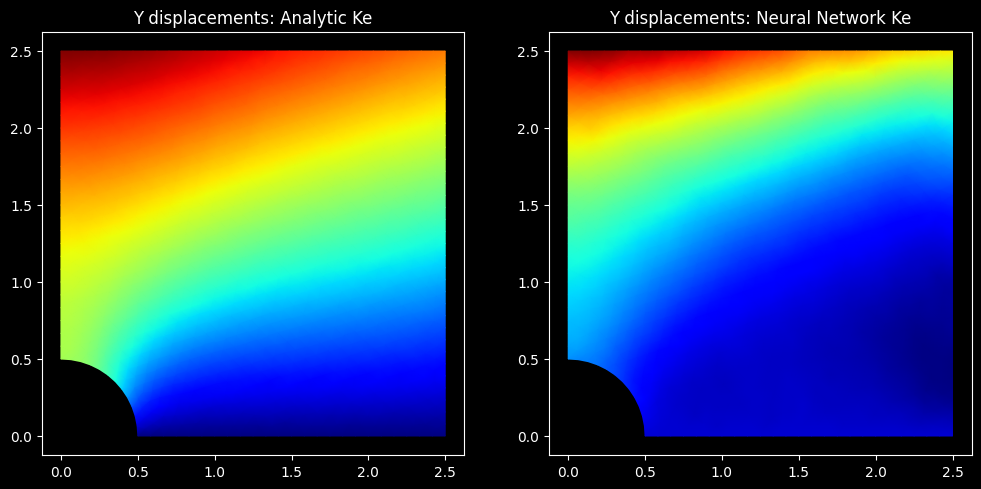

In [31]:
# Plotting stresses
# = = = = = = = = = = = = = =

Xs = []
Ys = []
Tris = []

for node_id in nodes_dict:
    Xs.append(nodes_dict[node_id][0])
    Ys.append(nodes_dict[node_id][1])
    
for elem_id in elems_dict:
    node_1, node_2, node_3 = elems_dict[elem_id]
    Tris.append((node_1, node_2, node_3))
    
mesh = tri.Triangulation(Xs, Ys, Tris)

fig, axes = plt.subplots(1, 2, figsize = (12, 5.5))
# axes.set_title(r'$\sigma$', fontsize = 20)
# axes.set_xlabel('X', fontsize = 15)
# axes.set_ylabel('Y', fontsize = 15)

displs_analyt = np.zeros(len(nodes_dict))
displs_neural = np.zeros(len(nodes_dict))
for i in range(len(nodes_dict)):
    idx = 2*i
    ux = U_analyt[idx]
    uy = U_analyt[idx+1]
    displs_analyt[i] = uy
    ux = U_neural[idx]
    uy = U_neural[idx+1]
    displs_neural[i] = uy

plt.style.use('dark_background')
pos0 = axes[0].tripcolor(mesh, displs_analyt, cmap = 'jet', edgecolors = 'black', shading = 'gouraud')
pos1 = axes[1].tripcolor(mesh, displs_neural, cmap = 'jet', edgecolors = 'black', shading = 'gouraud')

axes[0].set_title('Y displacements: Analytic Ke')
axes[1].set_title('Y displacements: Neural Network Ke')
plt.show()